In this notebook: fit pure 2D exponential to razor data

In [1]:
import os
os.environ['THEANO_FLAGS'] = "device=cpu"

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import theano as th
import theano.tensor as T
import pymc3 as pm
import pickle
import csv
from statistics import median
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

th.config.compute_test_value = 'ignore'

In [2]:
# Get the data
boxes = ['MultiJet', 'DiJet', 'LeptonMultiJet', 'LeptonJet']
sideband_x = {'MultiJet':650, 'DiJet':650, 'LeptonMultiJet':550, 'LeptonJet':550}
sideband_y = {'MultiJet':0.3, 'DiJet':0.3, 'LeptonMultiJet':0.2, 'LeptonJet':0.2}
btag_max = {'MultiJet':3, 'DiJet':2, 'LeptonMultiJet':3, 'LeptonJet':2}
data = { box:pd.read_csv("data/RazorFitInstance_Razor2016_MoriondRereco_{}.csv".format(box), index_col='NBtags')
           for box in boxes }
sideband_data = { box:data[box][ (data[box]['MR'] < sideband_x[box]) | (data[box]['Rsq'] < sideband_y[box]) ]
                    for box in boxes}

<IPython.core.display.Javascript object>


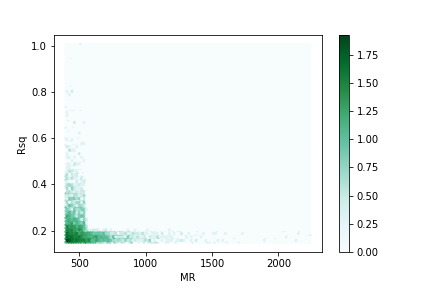

In [21]:
# Check the data
%matplotlib notebook
ax = sideband_data['LeptonMultiJet'].plot(kind='hexbin', x='MR', y='Rsq', bins='log', sharex=False);
plt.show()

In [4]:
class Sideband(object):
    """Class storing razor sideband geometry info."""
    def __init__(self, MRMin=500, MRMax=4000, RsqMin=0.25, RsqMax=1.5, 
                MRSidebandMax=650, RsqSidebandMax=0.30):
        self.MRMin = T.as_tensor_variable(MRMin)
        self.MRMax = T.as_tensor_variable(MRMax)
        self.RsqMin = T.as_tensor_variable(RsqMin)
        self.RsqMax = T.as_tensor_variable(RsqMax)
        self.MRSidebandMax = T.as_tensor_variable(MRSidebandMax)
        self.RsqSidebandMax = T.as_tensor_variable(RsqSidebandMax)
        
        # as floats
        self.MRMin_ = MRMin
        self.MRMax_ = MRMax
        self.RsqMin_ = RsqMin
        self.RsqMax_ = RsqMax
        self.MRSidebandMax_ = MRSidebandMax
        self.RsqSidebandMax_ = RsqSidebandMax
        
    def in_sideband(self, MR, Rsq):
        not_in = ( (MR < self.MRMin) + (MR > self.MRMax) + (Rsq < self.RsqMin) + (Rsq > self.RsqMax) 
                  + ((MR > self.MRSidebandMax)*(Rsq > self.RsqSidebandMax)) )
        return not_in < 1
        
hadronic_sideband = Sideband(500, 4000, 0.25, 1.5, 650, 0.30)
leptonic_sideband = Sideband(400, 4000, 0.15, 1.5, 550, 0.20)

hadronic_mr_sideband = Sideband(500, 650, 0.25, 1.5, 650, 1.5)
hadronic_rsq_sideband = Sideband(500, 4000, 0.25, 0.30, 4000, 0.30)

leptonic_mr_sideband = Sideband(400, 550, 0.15, 1.5, 550, 1.5)
leptonic_rsq_sideband = Sideband(400, 4000, 0.15, 0.20, 4000, 0.20)

In [5]:
# Using scipy's integration functionality we can directly compute the razor pdf integral numerically.
# This may allow us to move to pdfs whose norm is not analytically calculable.  

def razor_p(MR, Rsq, b):
    """Computes razor probability density (numpy version)."""
    term1 = b * MR * Rsq
    prob = np.exp(-term1)
    return prob

def razor_int(b, MRMin, MRMax, RsqMin, RsqMax):
    """Computes razor integral in a rectangular region"""
    func = lambda y, x: razor_p(x, y, b)
    RsqLow = lambda x: RsqMin
    RsqHigh = lambda x: RsqMax
    return sp.integrate.dblquad(func, MRMin, MRMax, RsqLow, RsqHigh)[0]

def razor_norm(b, sideband):
    norm_MR_sideband = razor_int(b, sideband.MRMin_, sideband.MRSidebandMax_, 
                                          sideband.RsqMin_, sideband.RsqMax_ )
    norm_Rsq_sideband = razor_int(b, sideband.MRSidebandMax_, sideband.MRMax_, 
                                          sideband.RsqMin_, sideband.RsqSidebandMax_ )
    return norm_MR_sideband + norm_Rsq_sideband

def razor_p_sidebandnormalized(MR, Rsq, b, nevents, sideband=hadronic_sideband):
    """Returns probability normalized to the given number of events in the given sideband"""
    p = razor_p(MR, Rsq, b)
    norm = razor_norm(b, sideband)
    return nevents*p/norm

class RazorIntegral(th.Op):
    """Inputs: b, MRMin, MRMax, RsqMin, RsqMax
       Output: pdf integral"""
    __props__ = ()
    epsilon = 1e-7
    
    def make_node(self, *inputs):
        inputs = [T.as_tensor_variable(inp) for inp in inputs]
        output = T.dscalar()
        return th.Apply(self, inputs, [output])
    
    def perform(self, node, inputs, output_storage):
        b, MRMin, MRMax, RsqMin, RsqMax = inputs
        func = lambda y, x: razor_p(x, y, b)
        RsqLow = lambda x: RsqMin
        RsqHigh = lambda x: RsqMax
        pdf_integral = sp.integrate.dblquad( func, MRMin, MRMax, RsqLow, RsqHigh )[0]
        
        res = output_storage[0]
        res[0] = np.array(pdf_integral)
        
    def grad(self, inputs, g):
        b, MRMin, MRMax, RsqMin, RsqMax = inputs
        out_grad = g[0]
        e = self.epsilon
        b_grad = (razor_integral(b + e, MRMin, MRMax, RsqMin, RsqMax) 
                  - razor_integral(b - e, MRMin, MRMax, RsqMin, RsqMax)) / (2 * e)
        MRMin_grad = MRMin.zeros_like()
        MRMax_grad = MRMax.zeros_like()
        RsqMin_grad = RsqMin.zeros_like()
        RsqMax_grad = RsqMax.zeros_like()
        return [out_grad * gr for gr in [b_grad, MRMin_grad, MRMax_grad, RsqMin_grad, RsqMax_grad]]
   
        
razor_integral = RazorIntegral()

In [6]:
# Create PyMC3 class for razor PDF
from pymc3.distributions import Continuous
from pymc3.distributions.dist_math import bound

class Razor(Continuous):
    def __init__(self, b, sideband, **kwargs):
        super(Razor, self).__init__(**kwargs)
        self.b = b
        self.sideband = sideband
        
    def in_sideband(self, MR, Rsq):
        return self.sideband.in_sideband(MR, Rsq)
        
    def norm(self):
        b = self.b
        norm_MR_sideband = razor_integral(b, self.sideband.MRMin, self.sideband.MRSidebandMax, 
                                          self.sideband.RsqMin, self.sideband.RsqMax )
        norm_Rsq_sideband = razor_integral(b, self.sideband.MRSidebandMax, self.sideband.MRMax, 
                                          self.sideband.RsqMin, self.sideband.RsqSidebandMax )
        return norm_MR_sideband + norm_Rsq_sideband

    def logp(self, values):
        MR = values[:,0]
        Rsq = values[:,1]
        b = self.b
        
        term1 = b * MR * Rsq
        logprob = -term1
        lognorm = T.log(self.norm())
        return bound(logprob - lognorm, b > 0)

In [36]:
# Model setup and training

def build_model(data, nbtags, box='MultiJet',
               prior_slopes=[0.1],
               initial_vals=[0.015], 
               sideband=None):
    """Create PyMC3 model with razor pdf and observed data.
        prior_slopes: slopes for the exponential prior on b
        initial_vals: test value for b"""
    with pm.Model() as model:
        # PDF variables
        b = pm.Exponential("b", prior_slopes[0], testval=initial_vals[0])
        
        if sideband is not None:
            sband = sideband
        elif box in ['LeptonJet','LeptonMultiJet']:
            sband = leptonic_sideband
        else:
            sband = hadronic_sideband
            
        observed = data.ix[nbtags][['MR','Rsq']].values
        razor_pdf = Razor("razor_pdf", b=b, sideband=sband,
                          shape=len(observed), observed=observed)
    return model

def fit_model(model, samples=20000, burn_period=10000):
    """Fit the model using the NUTS sampler and return
        samples from the posterior"""
    with model:
        step = pm.Metropolis()
        trace = pm.sample(samples, step=step)
        burned_trace = trace[burn_period:]
    return burned_trace
    
def visualize_trace(trace):
    varnames = ['b']
    # Visualize posteriors and MCMC traces
    pm.plots.traceplot(trace=trace, varnames=varnames);
    plt.show()
    # Plot the autocorrelation of the MCMC traces.
    # Long tails on this plot mean that the Markov chain is not sampling uniformly from the posterior.
    pm.plots.autocorrplot(trace=trace, varnames=varnames);
    plt.show()
    # Visualize the posteriors for the function parameters
    pm.plot_posterior(trace=trace, varnames=varnames);
    plt.show()
    
def fit_and_plot(data, nbtags, samples=20000, burn_period=10000, sideband=None, box='MultiJet'):
    """Build the model, fit it, and make diagnostic plots.
        Returns the MCMC trace."""
    model = build_model(data, nbtags, sideband=sideband, box=box)
    trace = fit_model(model, samples, burn_period)
    visualize_trace(trace)
    return trace

def save_traces(traces, fname):
    pickle.dump(traces, open(fname, "wb"))
    
def load_traces(fname):
    return pickle.load(open(fname, "rb"))

100%|██████████| 10000/10000 [01:31<00:00, 109.56it/s]


<IPython.core.display.Javascript object>


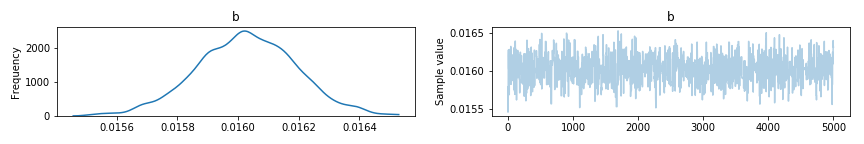

<IPython.core.display.Javascript object>


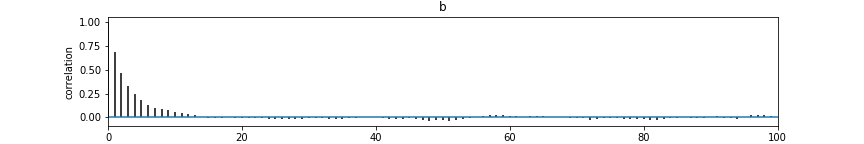

<IPython.core.display.Javascript object>


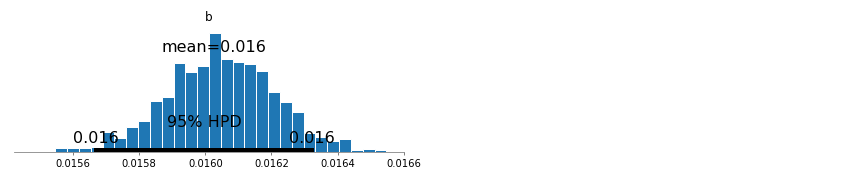

In [27]:
trace = fit_and_plot(sideband_data['MultiJet'], 0, samples=10000, burn_period=5000)

<IPython.core.display.Javascript object>


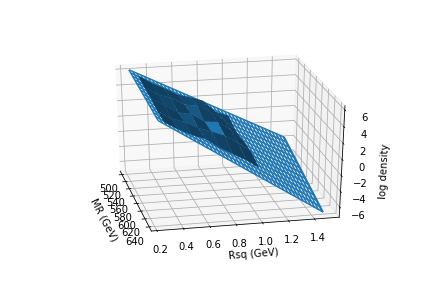

In [32]:
# Compare data and fit visually -- MR sideband
xstep = 10
ystep = 0.01
xmin = 500
xsidebandmax = 650
xmax = 4000
ymin = 0.25
ysidebandmax = 0.30
ymax = 1.5
the_sideband = hadronic_sideband
nx = int((xsidebandmax-xmin)/xstep)
ny = int((ymax-ymin)/ystep)
gridx_ = np.arange(xmin, xsidebandmax, xstep)
gridy_ = np.arange(ymin, ymax, ystep)
gridx, gridy = np.meshgrid(gridx_, gridy_)

# Data
binstepx = 30
binstepy = 0.1
d = sideband_data['MultiJet'].ix[0]
data_bins = (np.arange(xmin, xsidebandmax+binstepx, binstepx), np.arange(ymin, ymax+binstepy, binstepy)) 
data_hist = np.log(np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]).T - np.log(binstepx*binstepy)
data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., (data_bins[1][:-1]+data_bins[1][1:])/2.)
data_norm = len(d)

# Fit 
pdf_vals = np.zeros((nx, ny))
pdf_vals = np.log(razor_p_sidebandnormalized(gridx, gridy, trace["b"][1000], data_norm, sideband=the_sideband))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(gridx, gridy, pdf_vals)
ax.plot_surface(data_binsx, data_binsy, data_hist)
ax.set_xlabel('MR (GeV)')
ax.set_ylabel('Rsq (GeV)')
ax.set_zlabel('log density')
plt.show()

<IPython.core.display.Javascript object>


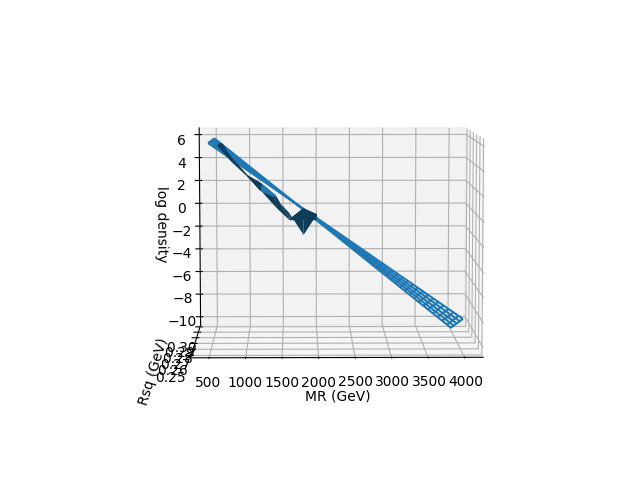

In [156]:
# Compare data and fit visually -- Rsq sideband
xstep = 10
ystep = 0.01
nx = int((4000-500)/xstep)
ny = int((0.30-0.25)/ystep)
gridx_ = np.arange(500, 4000, xstep)
gridy_ = np.arange(0.25, 0.30, ystep)
gridx, gridy = np.meshgrid(gridx_, gridy_)

# Data
binstepx = 200
binstepy = 0.02
d = sideband_data['MultiJet'].ix[0]
data_bins = (np.arange(500, 4000+binstepx, binstepx), np.arange(0.25, 0.30+binstepy, binstepy)) 
data_hist = np.log(np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]).T - np.log(binstepx*binstepy)
data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., (data_bins[1][:-1]+data_bins[1][1:])/2.)
data_norm = len(d)

# Fit 
pdf_vals = np.zeros((nx, ny))
pdf_vals = np.log(razor_p_sidebandnormalized(gridx, gridy, trace["b"][1000], data_norm))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(gridx, gridy, pdf_vals)
ax.plot_surface(data_binsx, data_binsy, data_hist)
ax.set_xlabel('MR (GeV)')
ax.set_ylabel('Rsq (GeV)')
ax.set_zlabel('log density')
plt.show()

In [ ]:
# Visualize fit residuals (viziduals)
xstep = 10
ystep = 0.01
nx = int((650-500)/xstep)
ny = int((1.5-0.25)/ystep)
gridx_ = np.arange(500, 650, xstep)
gridy_ = np.arange(0.25, 1.5, ystep)
gridx, gridy = np.meshgrid(gridx_, gridy_)

# Data
binstepx = 30
binstepy = 0.1
d = sideband_data['MultiJet'].ix[0]
data_bins = (np.arange(500, 650+binstepx, binstepx), np.arange(0.25, 1.5+binstepy, binstepy)) 
data_hist = np.log(np.histogram2d(d["MR"], d["Rsq"], bins=data_bins)[0]).T - np.log(binstepx*binstepy)
data_binsx, data_binsy = np.meshgrid((data_bins[0][:-1]+data_bins[0][1:])/2., (data_bins[1][:-1]+data_bins[1][1:])/2.)
data_norm = len(d)

# Fit 
pdf_vals = np.zeros((nx, ny))
pdf_vals = np.log(razor_p_sidebandnormalized(gridx, gridy, trace["b"][1000], data_norm))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(gridx, gridy, pdf_vals, rstride=10, cstride=10)
ax.plot_surface(data_binsx, data_binsy, data_hist)
ax.set_xlabel('MR (GeV)')
ax.set_ylabel('Rsq (GeV)')
ax.set_zlabel('log density')
plt.show()

In [37]:
def get_sideband_slopes(box):
    traces = {}
    bs = {}
    
    mr_sideband = hadronic_mr_sideband
    rsq_sideband = hadronic_rsq_sideband
    mrmax = 650
    rsqmax = 0.30
    if 'Lepton' in box:
        mr_sideband = leptonic_mr_sideband
        rsq_sideband = leptonic_rsq_sideband
        mrmax = 550
        rsqmax = 0.20
    d = sideband_data[box]
        
    for btags in range(3):
        traces[btags] = []
        bs[btags] = []
        print "Box {}, Btags {}".format(box, btags)   
        print "Standard sideband"
        traces[btags].append( 
            fit_and_plot(d, btags, samples=5000, burn_period=2500, box=box))
        b = traces[btags][-1]["b"].mean()
        bs[btags].append(b)
        print "b = {}\n".format(b)
        print "Box {}, Btags {}".format(box, btags)
        print "MR sideband only"
        traces[btags].append(
            fit_and_plot(d[ d['MR'] < mrmax ], btags, samples=5000, burn_period=2500, sideband=mr_sideband))
        b = traces[btags][-1]["b"].mean()
        bs[btags].append(b)
        print "b = {}\n".format(b)
        print "Box {}, Btags {}".format(box, btags)
        print "Rsq sideband only"
        traces[btags].append(
            fit_and_plot(d[ d['Rsq'] < rsqmax ], btags, samples=5000, burn_period=2500, sideband=rsq_sideband))
        b = traces[btags][-1]["b"].mean()
        bs[btags].append(b)
        print "b = {}\n".format(b)
    return traces, bs

Box DiJet, Btags 0
Standard sideband


100%|██████████| 5000/5000 [00:46<00:00, 107.82it/s]


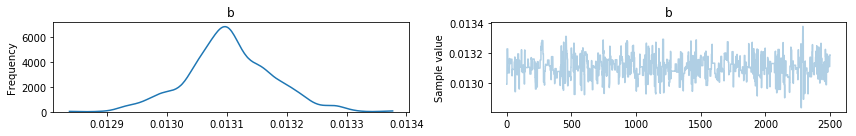

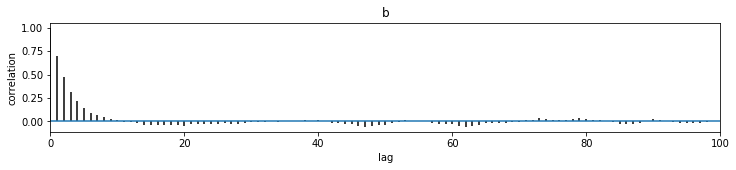

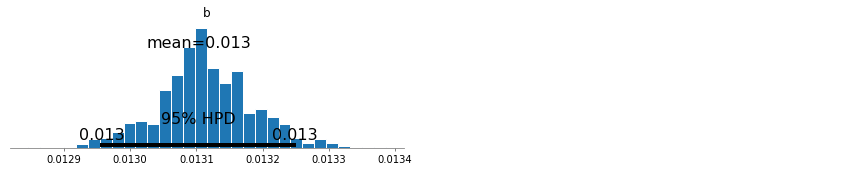

b = 0.0131042961706

Box DiJet, Btags 0
MR sideband only


100%|██████████| 5000/5000 [00:45<00:00, 109.03it/s]


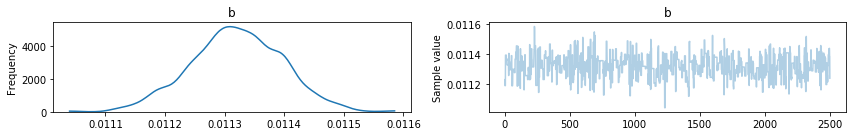

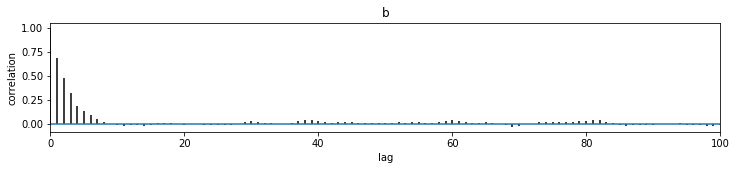

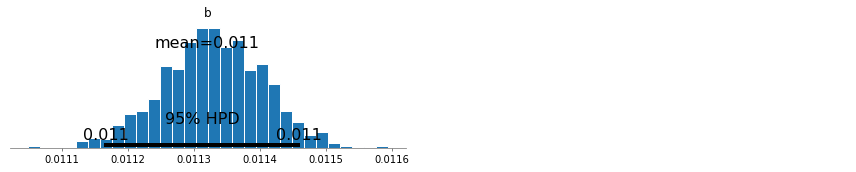

b = 0.0113199769727

Box DiJet, Btags 0
Rsq sideband only


100%|██████████| 5000/5000 [01:25<00:00, 58.26it/s]


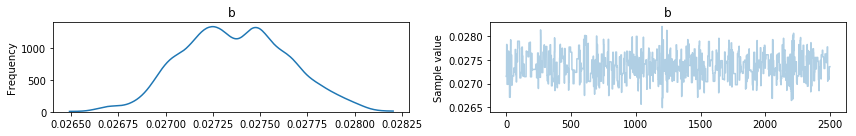

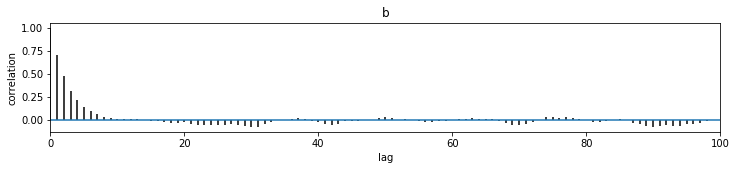

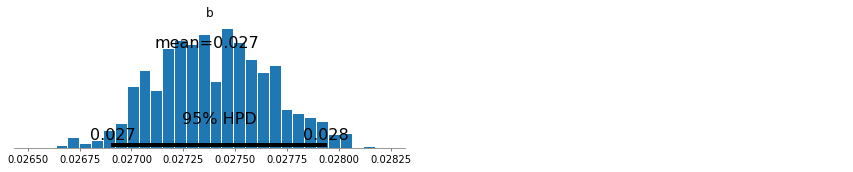

b = 0.0273658157484

Box DiJet, Btags 1
Standard sideband


100%|██████████| 5000/5000 [00:45<00:00, 110.74it/s]


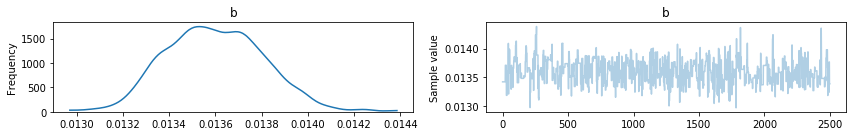

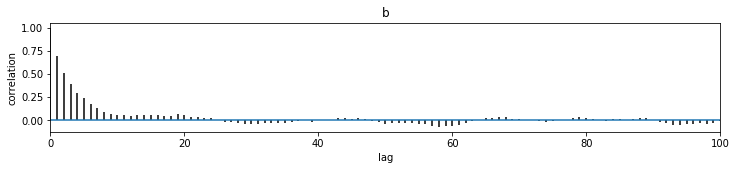

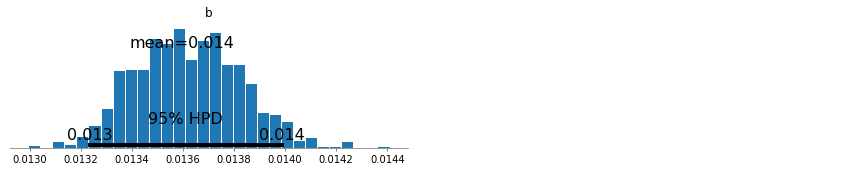

b = 0.0135965476828

Box DiJet, Btags 1
MR sideband only


100%|██████████| 5000/5000 [00:45<00:00, 110.96it/s]


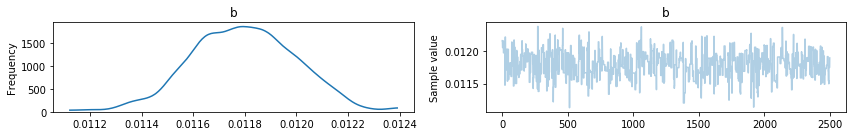

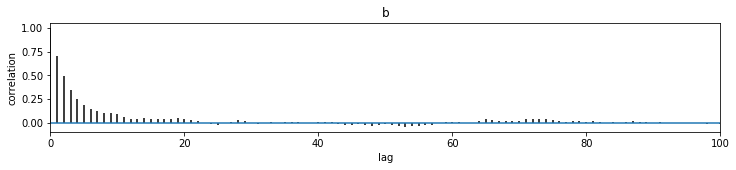

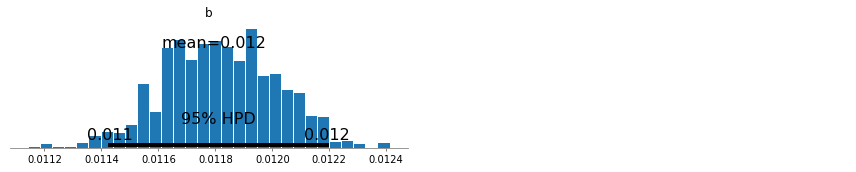

b = 0.0117947230927

Box DiJet, Btags 1
Rsq sideband only


100%|██████████| 5000/5000 [01:26<00:00, 57.76it/s]


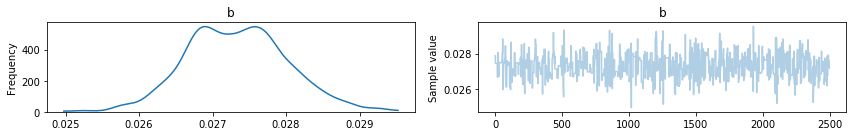

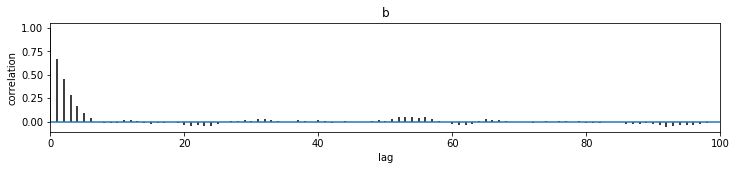

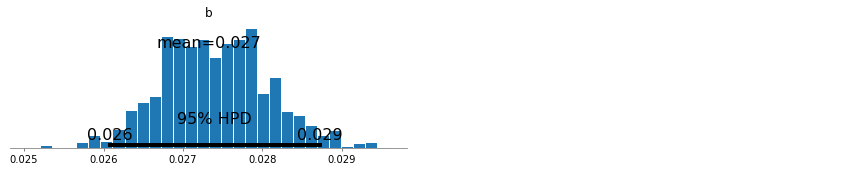

b = 0.0273258358951

Box DiJet, Btags 2
Standard sideband


100%|██████████| 5000/5000 [00:46<00:00, 107.53it/s]


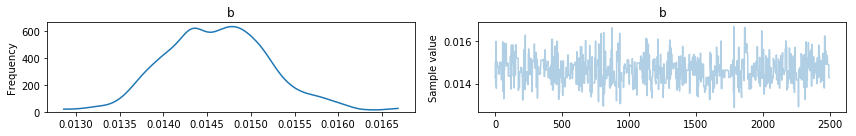

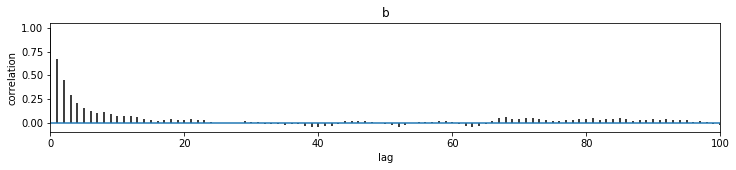

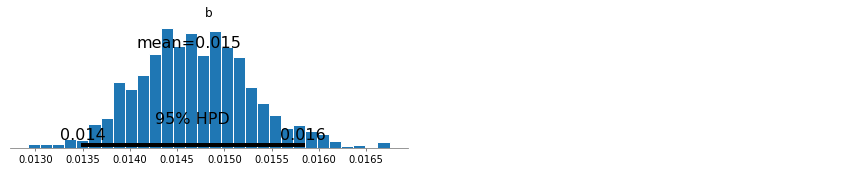

b = 0.0146217959636

Box DiJet, Btags 2
MR sideband only


100%|██████████| 5000/5000 [00:45<00:00, 109.61it/s]


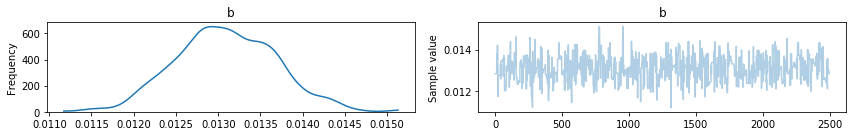

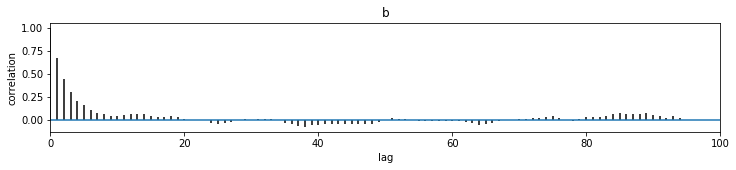

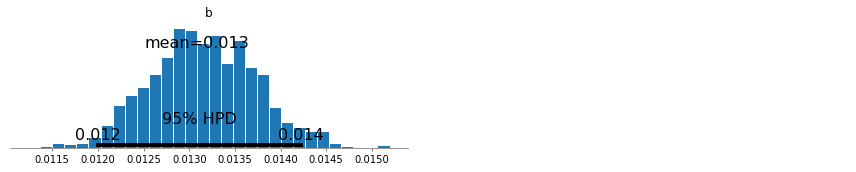

b = 0.0130824565173

Box DiJet, Btags 2
Rsq sideband only


100%|██████████| 5000/5000 [01:28<00:00, 67.06it/s]


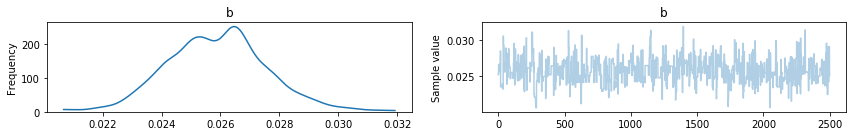

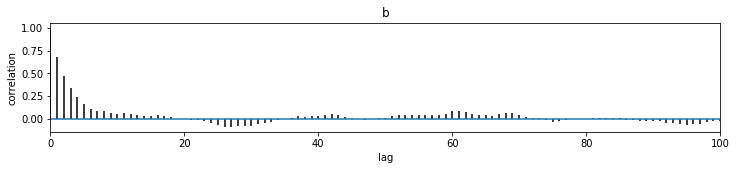

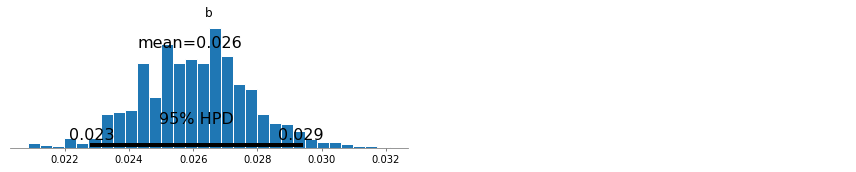

b = 0.0258892549733



In [34]:
# Check exponential slope in MR and Rsq sideband separately
%matplotlib inline
traces_dijet, bs_dijet = get_sideband_slopes('DiJet')     
%matplotlib notebook

Box LeptonMultiJet, Btags 0
Standard sideband


100%|██████████| 5000/5000 [00:56<00:00, 89.07it/s] 


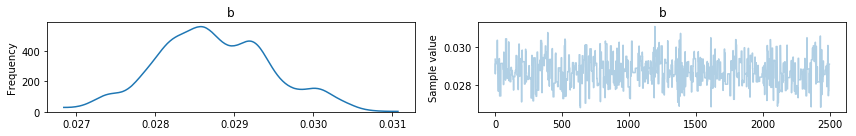

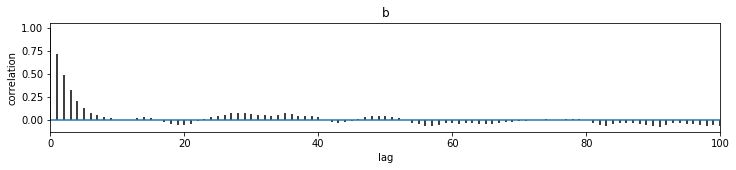

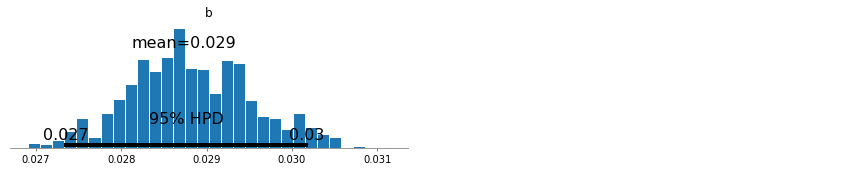

b = 0.0287393580925

Box LeptonMultiJet, Btags 0
MR sideband only


100%|██████████| 5000/5000 [00:52<00:00, 95.79it/s] 


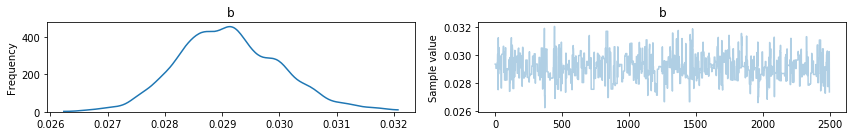

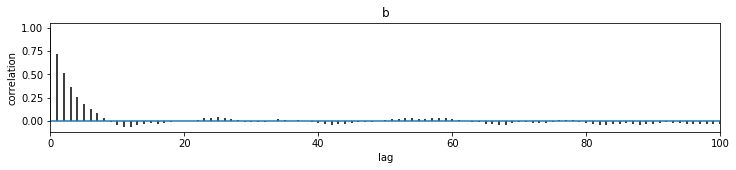

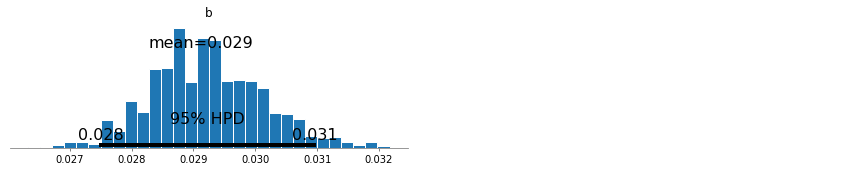

b = 0.0291194012994

Box LeptonMultiJet, Btags 0
Rsq sideband only


100%|██████████| 5000/5000 [01:21<00:00, 61.04it/s]


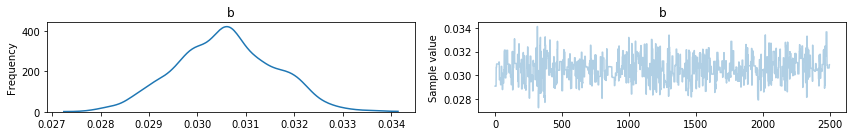

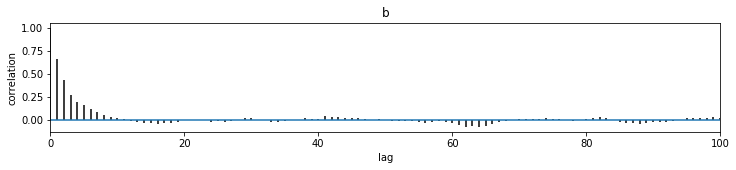

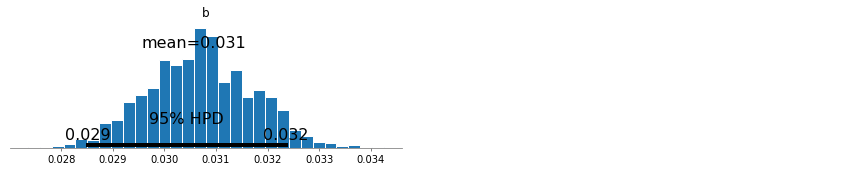

b = 0.0305787886565

Box LeptonMultiJet, Btags 1
Standard sideband


100%|██████████| 5000/5000 [01:26<00:00, 58.12it/s]


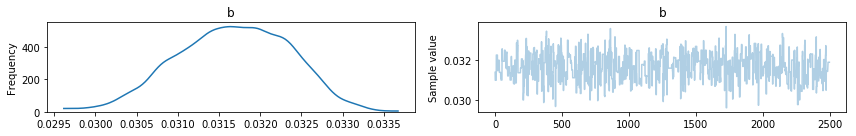

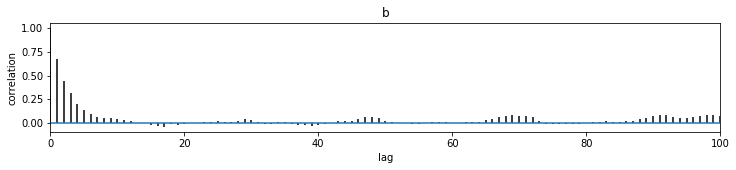

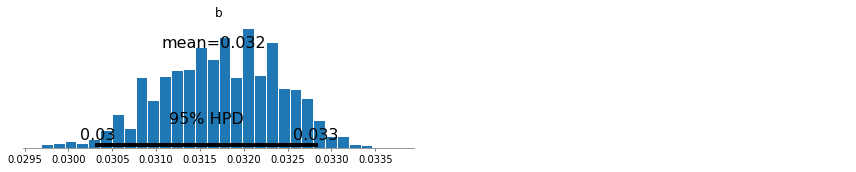

b = 0.0316622137374

Box LeptonMultiJet, Btags 1
MR sideband only


100%|██████████| 5000/5000 [00:53<00:00, 93.10it/s] 


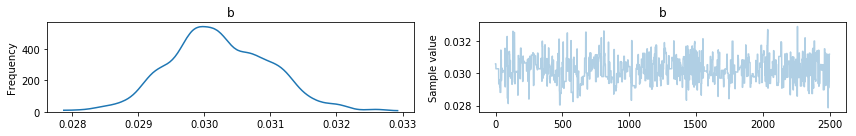

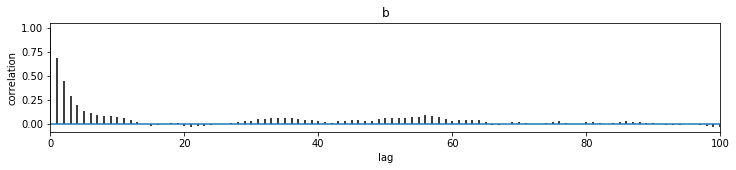

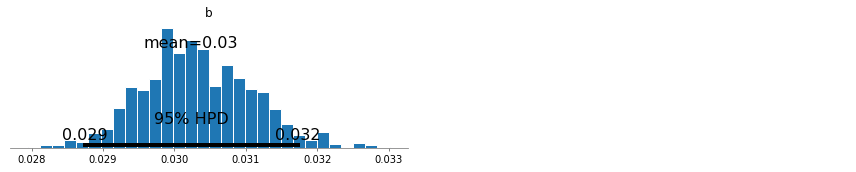

b = 0.0302333212364

Box LeptonMultiJet, Btags 1
Rsq sideband only


100%|██████████| 5000/5000 [01:27<00:00, 57.47it/s]


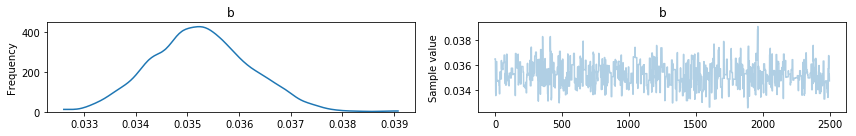

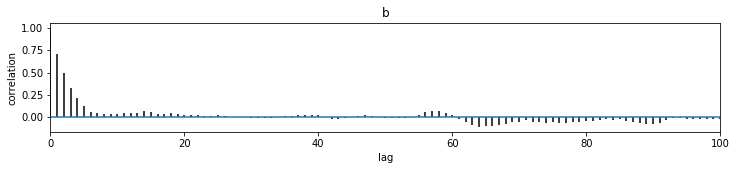

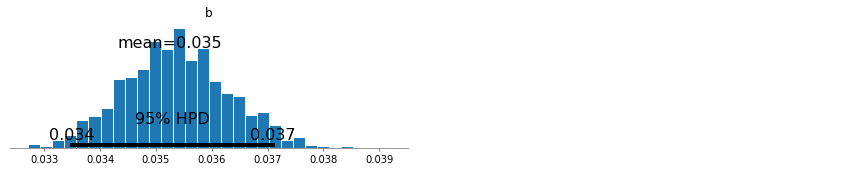

b = 0.0352575969422

Box LeptonMultiJet, Btags 2
Standard sideband


100%|██████████| 5000/5000 [01:23<00:00, 59.93it/s]


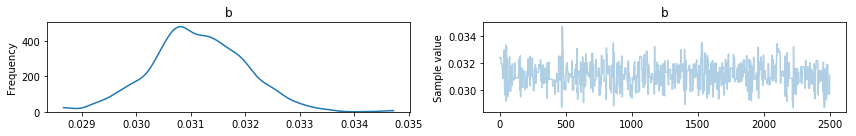

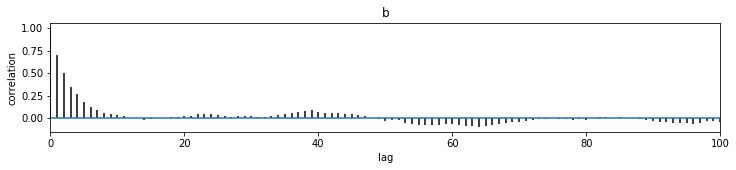

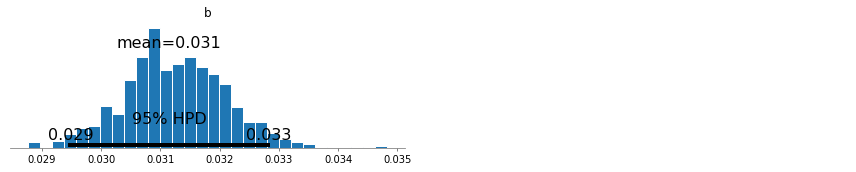

b = 0.031138135413

Box LeptonMultiJet, Btags 2
MR sideband only


100%|██████████| 5000/5000 [00:58<00:00, 86.05it/s] 


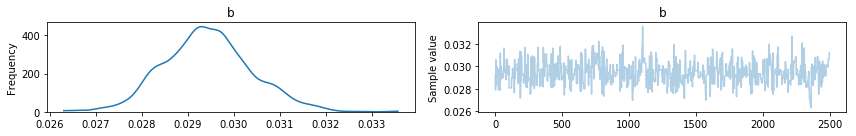

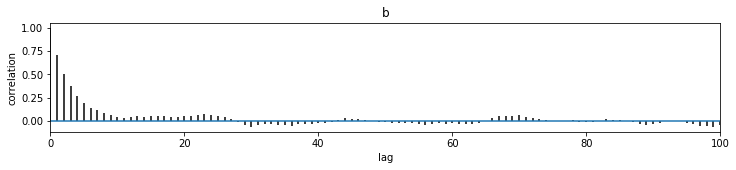

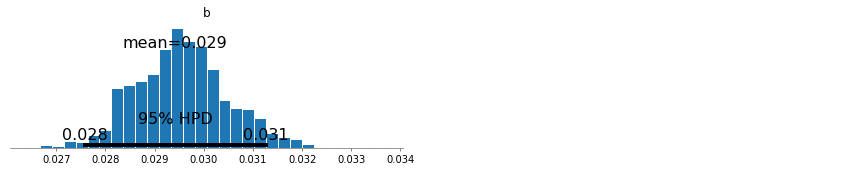

b = 0.0294220105393

Box LeptonMultiJet, Btags 2
Rsq sideband only


100%|██████████| 5000/5000 [01:26<00:00, 57.60it/s]


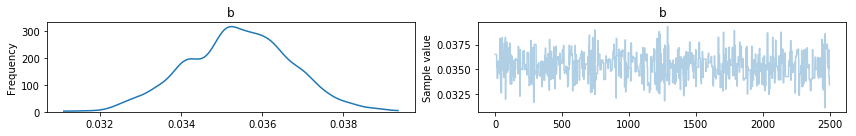

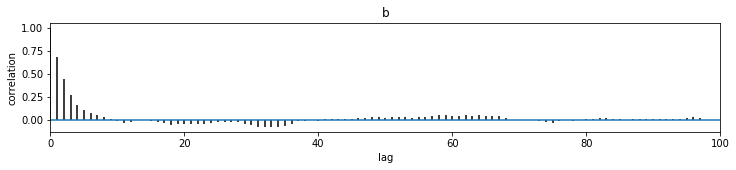

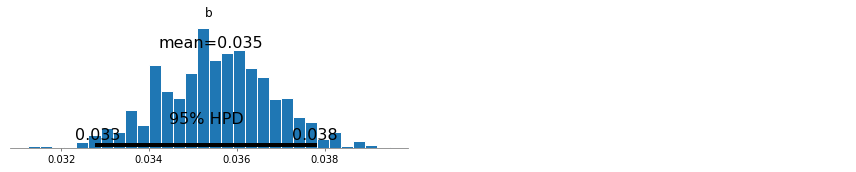

b = 0.035404231827



In [38]:
# Check exponential slope in MR and Rsq sideband separately
%matplotlib inline
traces_leptonmultijet, bs_leptonmultijet = get_sideband_slopes('LeptonMultiJet')     
%matplotlib notebook

Box LeptonJet, Btags 0
Standard sideband


100%|██████████| 5000/5000 [00:47<00:00, 104.69it/s]


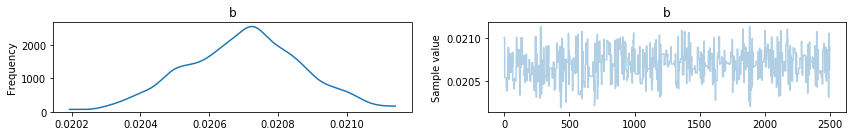

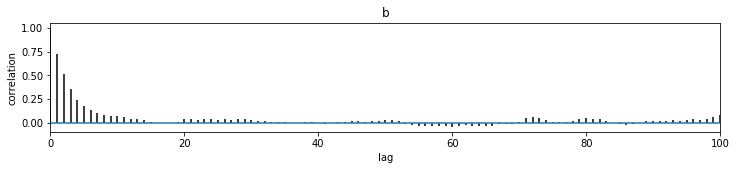

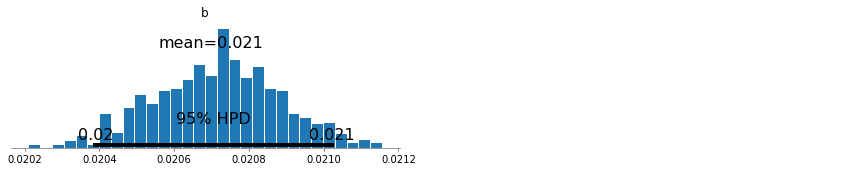

b = 0.0206986066516

Box LeptonJet, Btags 0
MR sideband only


100%|██████████| 5000/5000 [00:51<00:00, 96.98it/s] 


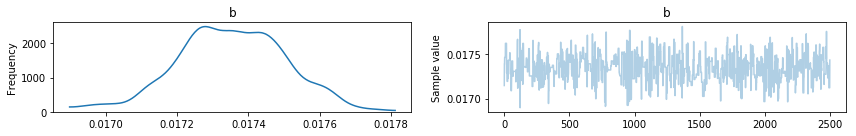

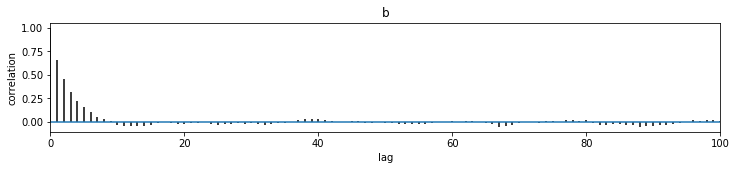

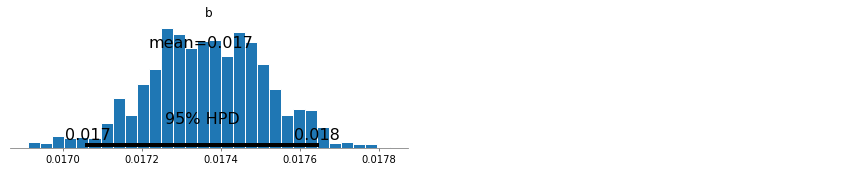

b = 0.0173501873482

Box LeptonJet, Btags 0
Rsq sideband only


100%|██████████| 5000/5000 [01:29<00:00, 63.72it/s]


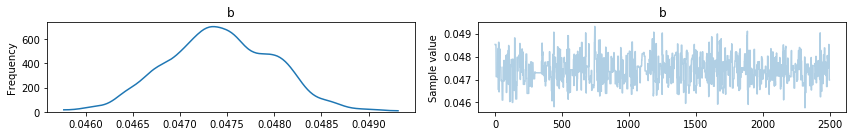

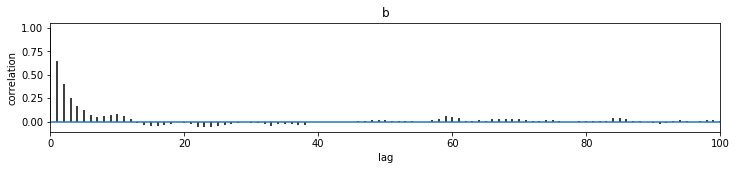

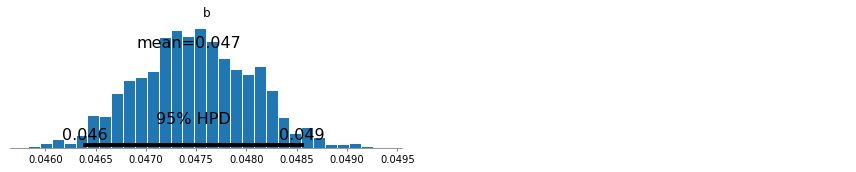

b = 0.0474260670498

Box LeptonJet, Btags 1
Standard sideband


 44%|████▍     | 2198/5000 [00:58<5:49:44,  7.49s/it]

ValueError: zero-size array to reduction operation minimum which has no identity

Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 882, in emit
    stream.write(fs % msg)
IOError: [Errno 5] Input/output error
Logged from file zmqstream.py, line 417
Traceback (most recent call last):
  File "/usr/lib/python2.7/logging/__init__.py", line 882, in emit
    stream.write(fs % msg)
IOError: [Errno 5] Input/output error
Logged from file zmqstream.py, line 452


In [ ]:
# Check exponential slope in MR and Rsq sideband separately
%matplotlib inline
traces_leptonjet, bs_leptonjet = get_sideband_slopes('LeptonJet')     
%matplotlib notebook

In [ ]:
# Check exponential slope in MR and Rsq sideband separately
%matplotlib inline
traces_multijet, bs_multijet = get_sideband_slopes('MultiJet')     
%matplotlib notebook